# **Forecasting Optimal Contact Center Staffing**

In modern banking operations, customer satisfaction depends heavily on efficient and timely service delivery through contact centers. An imbalance between customer call volume and available agents can lead to long wait times, poor service quality, and increased operational costs. Therefore, accurately forecasting call volumes is critical for workforce planning, cost optimization, and improving customer experience.

The goal of this project is to develop a time series forecasting model that predicts future call volumes in a banking contact center. These forecasts will be used to determine the optimal number of customer service agents required per hour/day, ensuring that staffing levels align with demand.

Data fields

- Interval - the date and time corresponding to the contact center activity
- Total Calls - the number of calls
- Total Calls Duration - the duration of the calls in seconds
- Missing Calls - the number of calls that reach Talkdesk platform but hung up before it was answered by an agent
- Available Time - agents time online and free to take a new call
- Away Time - agents time online and away from the computer unable to receive a new call
- Busy Time - agents time online and busy with tasks or meetings not related to handling calls
- On a Call Time - agents time online and handling (talking) with a contact
- After Call Work Time - agents time online and closing the contact interaction, for example, update ticket status on CRM systems
- Total Handle Time - total agents time from the point a call is answered until after the agent closes the contact interaction
- Occupancy Rate - agents time in an available status or handling a contact divided by the total agents time
- Utilization Rate - agents time actually handling interactions divided by the total agents time
- Shrinkage Rate - agents time occupied with not-handling interactions related tasks divided by the total agents time
- Agent Headcount - total staff count for the interval (target)

# Import libraries

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load dataset

In [173]:
df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\Advanced Machine Learning\End of module project\train.csv')
df.head()

,interval,total_calls,total_calls_duration,missing_calls,available_time,away_time,busy_time,on_a_call_time,after_call_work_time,total_handle_time,occupancy_rate,utilization_rate,shrinkage_rate,agent_headcount
0,2017-01-01 00:00:00,227,11880,8,9721,28806,0,14047,4543,18590,49.566679,32.547228,50.433321,56
1,2017-01-01 00:15:00,235,15297,4,10716,34697,0,16636,4932,21568,48.198743,32.200176,51.801257,60
2,2017-01-01 00:30:00,219,13739,5,16380,24186,0,16092,6280,22372,61.571705,35.546093,38.428295,61
3,2017-01-01 00:45:00,256,16534,5,8086,12307,0,16253,5932,22185,71.095401,52.104373,28.904599,57
4,2017-01-01 01:00:00,240,17692,14,8371,25296,0,18225,7217,25442,57.204487,43.042515,42.795513,61


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67104 entries, 0 to 67103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   interval              67104 non-null  object 
 1   total_calls           67104 non-null  int64  
 2   total_calls_duration  67104 non-null  int64  
 3   missing_calls         67104 non-null  int64  
 4   available_time        67104 non-null  int64  
 5   away_time             67104 non-null  int64  
 6   busy_time             67104 non-null  int64  
 7   on_a_call_time        67104 non-null  int64  
 8   after_call_work_time  67104 non-null  int64  
 9   total_handle_time     67104 non-null  int64  
 10  occupancy_rate        67104 non-null  float64
 11  utilization_rate      67104 non-null  float64
 12  shrinkage_rate        67104 non-null  float64
 13  agent_headcount       67104 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 7.2+ MB


In [175]:
df.describe()

,total_calls,total_calls_duration,missing_calls,available_time,away_time,busy_time,on_a_call_time,after_call_work_time,total_handle_time,occupancy_rate,utilization_rate,shrinkage_rate,agent_headcount
count,67104.000000,6.710400e+04,67104.000000,6.710400e+04,6.710400e+04,6.710400e+04,6.710400e+04,6.710400e+04,6.710400e+04,67104.000000,67104.000000,67104.000000,67104.000000
mean,201.687530,2.289175e+04,2.373718,2.100571e+04,2.628485e+04,1.839408e+04,2.274368e+04,5.469867e+03,2.821355e+04,52.870837,26.648778,35.867539,79.129799
std,192.385241,3.399462e+04,4.445029,4.862529e+04,3.863404e+04,3.548265e+04,2.993716e+04,1.303530e+04,3.591314e+04,27.649855,17.097233,23.937980,72.945244
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2.060000e+03,0.000000,4.424750e+03,2.218000e+03,0.000000e+00,1.870000e+03,4.730000e+02,2.468000e+03,36.820529,15.895618,17.796743,13.000000
50%,160.000000,1.489250e+04,1.000000,1.531100e+04,1.692050e+04,0.000000e+00,1.534000e+04,3.782000e+03,1.957900e+04,54.880799,27.957595,35.616922,61.000000
75%,332.000000,3.689625e+04,3.000000,2.959625e+04,3.379850e+04,2.184900e+04,3.794325e+04,8.019000e+03,4.649625e+04,73.846339,36.798536,55.218085,130.000000
max,7199.000000,3.631243e+06,325.000000,9.853390e+06,1.144860e+06,1.665431e+06,2.483933e+06,2.238978e+06,2.503274e+06,100.000000,100.000000,100.000000,347.000000


In [176]:
df.isnull().sum()

interval                0
total_calls             0
total_calls_duration    0
missing_calls           0
available_time          0
away_time               0
busy_time               0
on_a_call_time          0
after_call_work_time    0
total_handle_time       0
occupancy_rate          0
utilization_rate        0
shrinkage_rate          0
agent_headcount         0
dtype: int64

In [177]:
df.duplicated().sum()

np.int64(0)

# Data cleaning

Convert interval to Datetime and Sort

In [178]:
# Convert to datetime
df['interval'] = pd.to_datetime(df['interval'], errors='coerce')
df = df.sort_values('interval').reset_index(drop=True)
df = df.drop_duplicates(subset=['interval'])
df.head()

df['interval_diff'] = df['interval'].diff()
print(df['interval_diff'].value_counts().head())

df = df.drop(columns='interval_diff')
df = df.set_index('interval')
print(f"Duplicate timestamps: {df.index.duplicated().sum()}")
expected_count = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T').shape[0]
print(f"Expected rows: {expected_count}, Actual rows: {df.shape[0]}")

interval_diff
0 days 00:15:00    67103
Name: count, dtype: int64
Duplicate timestamps: 0
Expected rows: 67104, Actual rows: 67104


# EDA

Time Series Exploration

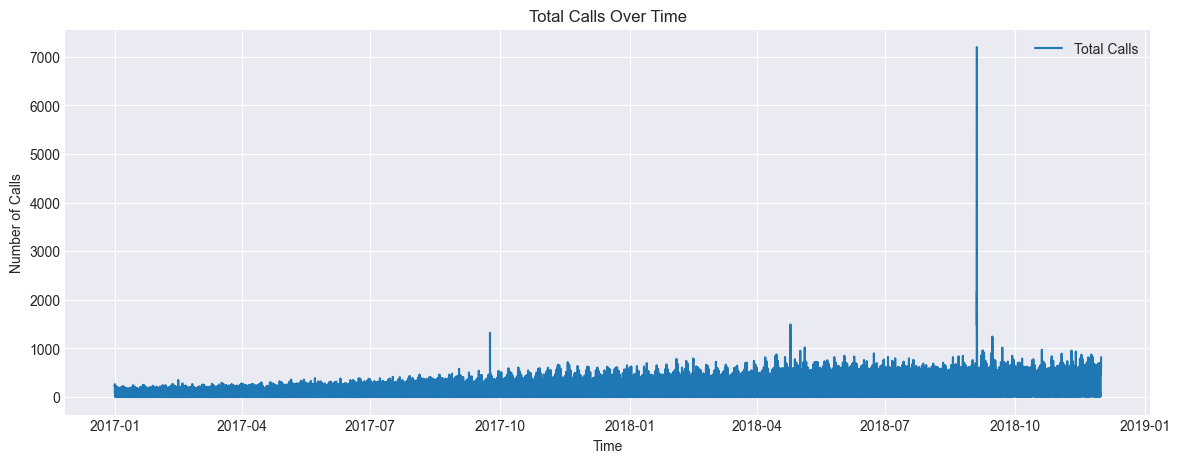

In [179]:
plt.figure(figsize=(14,5))
plt.plot(df['total_calls'], label='Total Calls')
plt.title('Total Calls Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

The time series plot for Total Calls Over Time reveals three key insights critical for staffing: a clear long-term upward trend indicating the need for a continually increasing agent headcount; a distinct high-frequency cyclical pattern (likely weekly or monthly seasonality) that requires forecasting models to include calendar-based regressors; and the presence of a massive, single-point outlier in mid-2018, which must be specifically addressed to prevent the forecasting model from severely overestimating future regular demand. Accurately modeling this trend and seasonality, while neutralizing the outlier's effect, is essential for translating call volume forecasts into optimal agent staffing levels using the Erlang C formula.

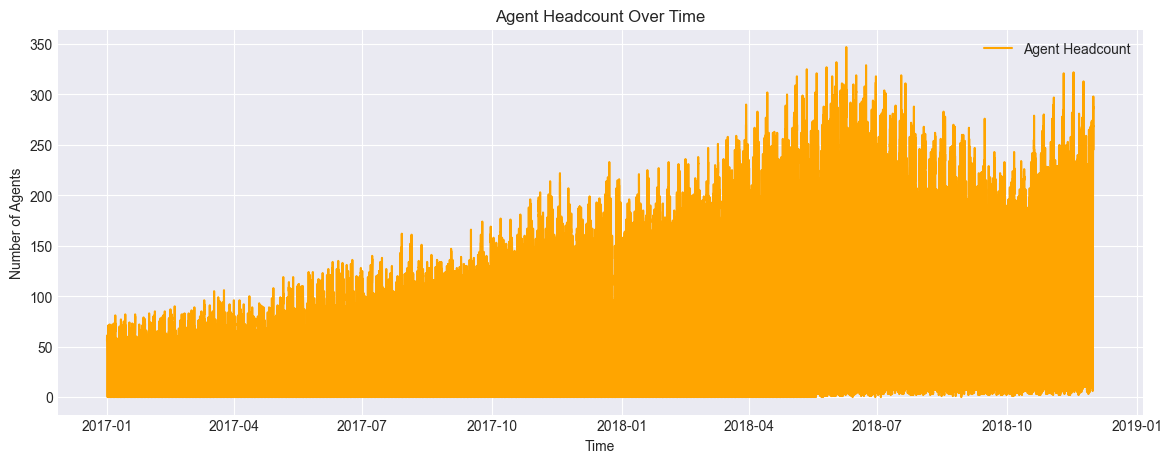

In [180]:
plt.figure(figsize=(14,5))
plt.plot(df['agent_headcount'], label='Agent Headcount', color='orange')
plt.title('Agent Headcount Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.legend()
plt.show()

The plot for Agent Headcount Over Time confirms that the bank's staffing levels closely mirror the dynamic demand seen in the call volume data. Specifically, the data shows a strong, sustained upward trend in the total number of agents, rising from a peak of around 75 in early 2017 to almost 350 in mid-2018, which aligns with the overall growth in call demand. Furthermore, the presence of regular, high-frequency cyclical peaks in the headcount demonstrates that the bank is proactively scheduling agents to cover expected daily or weekly spikes in call volume. The peak staffing in mid-2018, followed by a subsequent drop, suggests the workforce was scaled temporarily to manage the previously observed extreme call anomaly.

Daily and Weekly Patterns

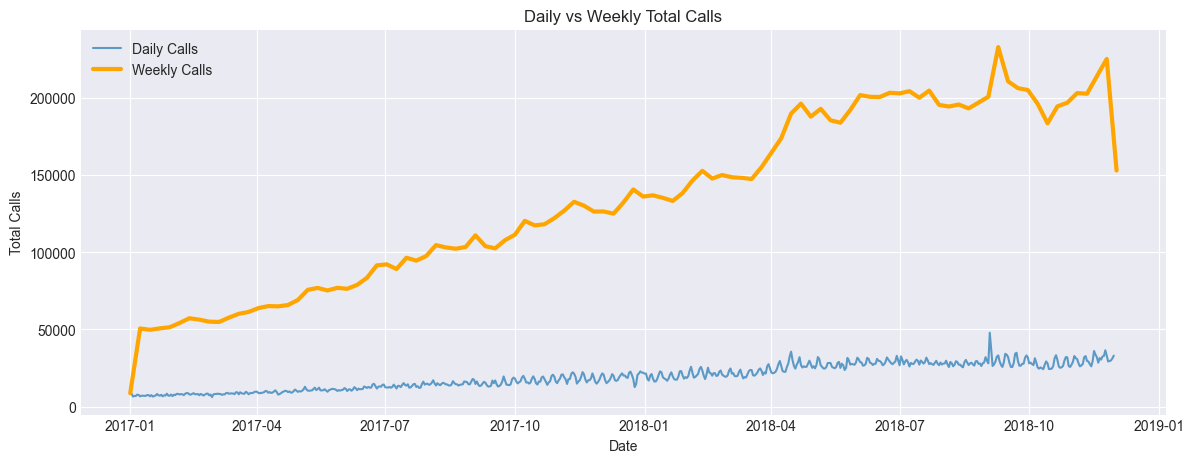

In [181]:
daily_calls = df['total_calls'].resample('D').sum()
weekly_calls = df['total_calls'].resample('W').sum()

plt.figure(figsize=(14,5))
plt.plot(daily_calls, label='Daily Calls', alpha=0.7)
plt.plot(weekly_calls, label='Weekly Calls', linewidth=3, color='orange')
plt.title('Daily vs Weekly Total Calls')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.show()

The plot comparing Daily vs. Weekly Total Calls clearly confirms a strong, sustained upward trend in call volume across both 2017 and 2018, rising to weekly peaks over 225,000 calls, and pronounced multi-level seasonality. The overall growth validates the need for continuous expansion in the Agent Headcount, while the high-frequency fluctuations in the daily data reinforce the necessity of including calendar-based variables (like day-of-week) in the forecasting model to accurately capture the weekly peaks and troughs. The final, sharp drop at the end of 2018 likely reflects holiday seasonality and must be accounted for in the annual forecast.

Correlation Analysis

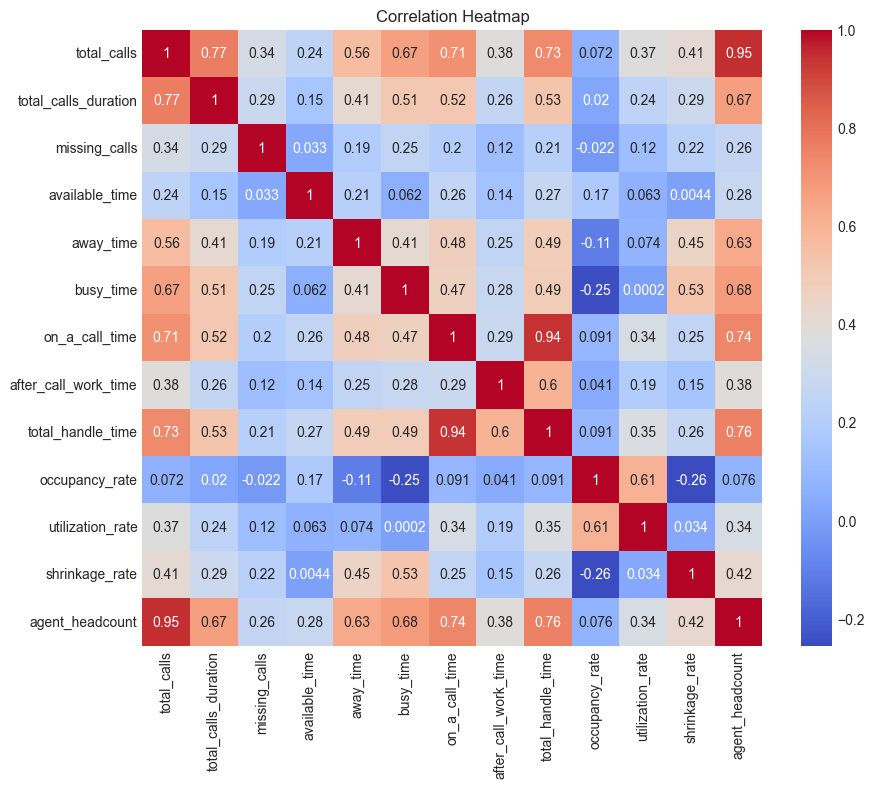

In [182]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The Correlation Heatmap confirms the project's strategy by showing a near-perfect correlation (0.95) between the primary demand variable, Total Calls, and the final target variable, Agent Headcount. Strong positive correlations (around 0.70 to 0.77) also exist between Total Calls and time-related metrics like Total Calls Duration, On a Call Time, and Total Handle Time. These duration metrics are crucial, as they will be used to calculate the Average Handle Time (AHT) and can also serve as powerful exogenous variables in the time series forecasting model to improve the predictive accuracy of the call volume.

Hourly / Weekly Seasonality

<Axes: title={'center': 'Average Calls by Day of Week'}, xlabel='day_of_week'>

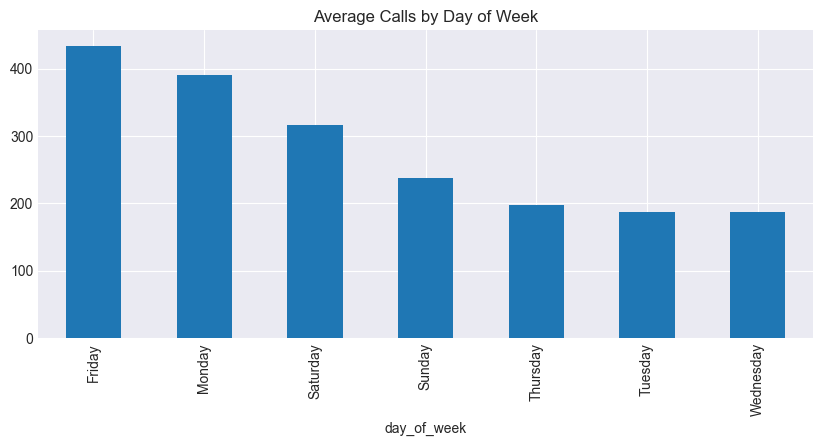

In [183]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_name()

df.groupby('hour')['total_calls'].mean().plot(kind='bar', figsize=(10,4), title='Average Calls by Hour')
df.groupby('day_of_week')['total_calls'].mean().plot(kind='bar', figsize=(10,4), title='Average Calls by Day of Week')

The chart for Average Calls by Day of Week identifies a crucial element of the contact center's seasonality, confirming that demand is highly uneven throughout the week. Call volumes peak dramatically on Friday and Monday (both averaging near 400 calls), indicating that staffing must be highest on these two days to maintain service levels. Conversely, call volumes are lowest and most consistent mid-week on Tuesday, Wednesday, and Thursday (averaging around 200 calls), allowing for staffing reductions and off-phone activities.

Relationship Between Calls and Staffing

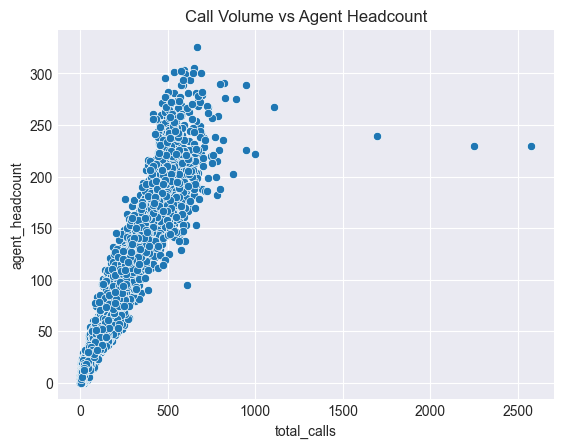

In [184]:
sns.scatterplot(x='total_calls', y='agent_headcount', data=df.sample(5000))
plt.title('Call Volume vs Agent Headcount')
plt.show()

The scatter plot illustrates a strong positive relationship between call volume and agent headcount, indicating that staffing levels generally rise as the number of incoming calls increases. Most data points are concentrated between 0–800 total calls and 0–300 agents, suggesting consistent scheduling practices that align staffing with expected demand. However, the pattern begins to flatten at higher call volumes, implying that increases in agent numbers do not fully keep pace with surges in calls—possibly due to staffing limits or fixed scheduling. A few outliers with unusually high call volumes and moderate staffing levels may represent exceptional peak periods or system events.

Time Series Decomposition

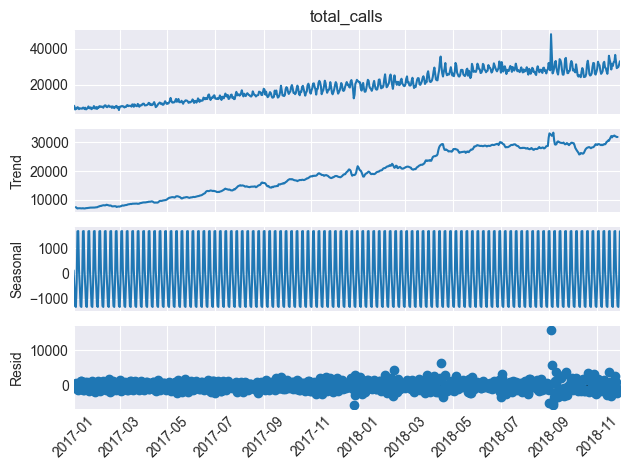

In [185]:
result = seasonal_decompose(daily_calls, model='additive')
fig = result.plot()

for ax in fig.get_axes():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

The Time Series Decomposition plot confirms three critical features of the total_calls data: a strong, non-linear upward trend that necessitates a forecasting model capable of robust extrapolation; a pronounced, high-frequency seasonal component with a consistent magnitude, demanding the use of seasonal terms or day-of-week variables; and the presence of extreme outliers and increasing residual variance.

# Feature engineering

# Time series structure

In [186]:
# Time-based Features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['week_of_year'] = df.index.isocalendar().week
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [187]:
# Lag Features
df['lag_1'] = df['total_calls'].shift(1)
df['lag_4'] = df['total_calls'].shift(4)
df['lag_96'] = df['total_calls'].shift(96)

In [188]:
# Rolling Window
df['rolling_mean_4'] = df['total_calls'].rolling(window=4).mean()
df['rolling_mean_96'] = df['total_calls'].rolling(window=96).mean()
df['rolling_std_4'] = df['total_calls'].rolling(window=4).std()

In [189]:
# Operational Efficiency Features
df['calls_per_agent'] = df['total_calls'] / df['agent_headcount'].replace(0, np.nan)
df['avg_call_duration'] = df['total_calls_duration'] / df['total_calls'].replace(0, np.nan)
df['busy_ratio'] = df['busy_time'] / (df['available_time'] + df['busy_time'] + df['away_time'])
df['productivity_ratio'] = df['on_a_call_time'] / df['total_handle_time'].replace(0, np.nan)

In [190]:
df = df.dropna().copy()

# Model building

# Regression-based Forecasting

In [191]:
# Target and Features
target = 'agent_headcount'
features = [
    'total_calls', 'total_calls_duration', 'missing_calls',
    'available_time', 'away_time', 'busy_time', 'on_a_call_time',
    'after_call_work_time', 'total_handle_time',
    'occupancy_rate', 'utilization_rate', 'shrinkage_rate',
    'hour', 'day', 'day_of_week', 'week_of_year', 'month', 'is_weekend',
    'lag_1', 'lag_4', 'lag_96',
    'rolling_mean_4', 'rolling_mean_96', 'rolling_std_4',
    'calls_per_agent', 'avg_call_duration', 'busy_ratio', 'productivity_ratio'
]

In [192]:
# Handle Missing Values
df_model = df.dropna(subset=features + [target]).copy()
if 'interval' in df.columns:
    df.index = pd.to_datetime(df['interval'])
    df = df.drop(columns=['interval'])

In [193]:
# Split into Train & Test Sets
df['target'] = df['agent_headcount'].shift(-1)
df = df.dropna()

# Define X and y
X = df.drop(columns=['target'])
y = df['target']
print(len(X), len(y))

57996 57996


In [194]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,shuffle=False,random_state=48)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(40597, 29) (40597,) (17399, 29) (17399,)


In [195]:
# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [196]:
# Linear regression
reg_model = LinearRegression()
reg_model.fit(x_train_scaled, y_train)

y_pred = reg_model.predict(x_test_scaled)
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Cross-validation
scores = cross_val_score(LinearRegression(),x_train_scaled,y_train,cv=5,scoring='r2')
print(scores, scores.mean())

R2 Score: 0.9787304510781996
MAE: 8.262108681414663
[0.94863507 0.97299261 0.97789947 0.9774065  0.97878007] 0.9711427452795078


In [197]:
# Ridge regression
tscv = TimeSeriesSplit(n_splits=5)
ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=0.01))
scores = cross_val_score(ridge_pipe,x_train,y_train,cv=tscv,scoring='r2')
print(scores, scores.mean())

[0.96921448 0.97794621 0.97525149 0.97672675 0.97981683] 0.9757911522193206


In [198]:
# Lasso
tscv = TimeSeriesSplit(n_splits=5)
lasso_pipe = make_pipeline(PolynomialFeatures(degree=1),StandardScaler(),Lasso(alpha=5, max_iter=5000))
scores = cross_val_score(lasso_pipe,x_train,y_train,cv=tscv,scoring='r2')
print(scores, scores.mean())

[0.90681109 0.93697655 0.94520987 0.95390734 0.96087969] 0.9407569091826946


In [199]:
# SVR
tscv = TimeSeriesSplit(n_splits=5)
model = make_pipeline(StandardScaler(),SVR(kernel='rbf', C=10))
scores = cross_val_score(model, X, y, cv=tscv, scoring="r2")
print(scores, scores.mean())

[0.57979722 0.72866242 0.05183638 0.95509593 0.88961812] 0.6410020147670156


In [200]:
# Random forest
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
scores = cross_val_score(rf, x_train, y_train, cv=tscv, scoring='r2')
print(scores, scores.mean())

[0.9361827  0.97576243 0.96544608 0.9767313  0.96567212] 0.9639589270299045


In [201]:
# Boosting
tscv = TimeSeriesSplit(n_splits=5)
xgb_pipe = make_pipeline(StandardScaler(),XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42,objective='reg:squarederror',tree_method='hist'))
scores = cross_val_score(xgb_pipe, X, y, cv=tscv, scoring='r2')
print(scores, scores.mean())

[0.93601047 0.94098029 0.95537477 0.98428311 0.97714829] 0.9587593867409687


The Ridge Regression model with an alpha value of 0.01 demonstrated excellent performance, achieving an average R² score of 0.97 across five TimeSeriesSplit folds. This indicates that the model effectively explains 97% of the variance in call volumes, showing strong predictive power and stability across time intervals. The consistent cross-validation scores confirm that the model generalizes well without significant overfitting, making it a reliable choice for forecasting call volumes in the contact center.

In [202]:
# fit ridge pipe
ridge_pipe = Ridge(alpha=0.01)
ridge_pipe.fit(x_train_scaled, y_train)

Ridge(alpha=0.01)

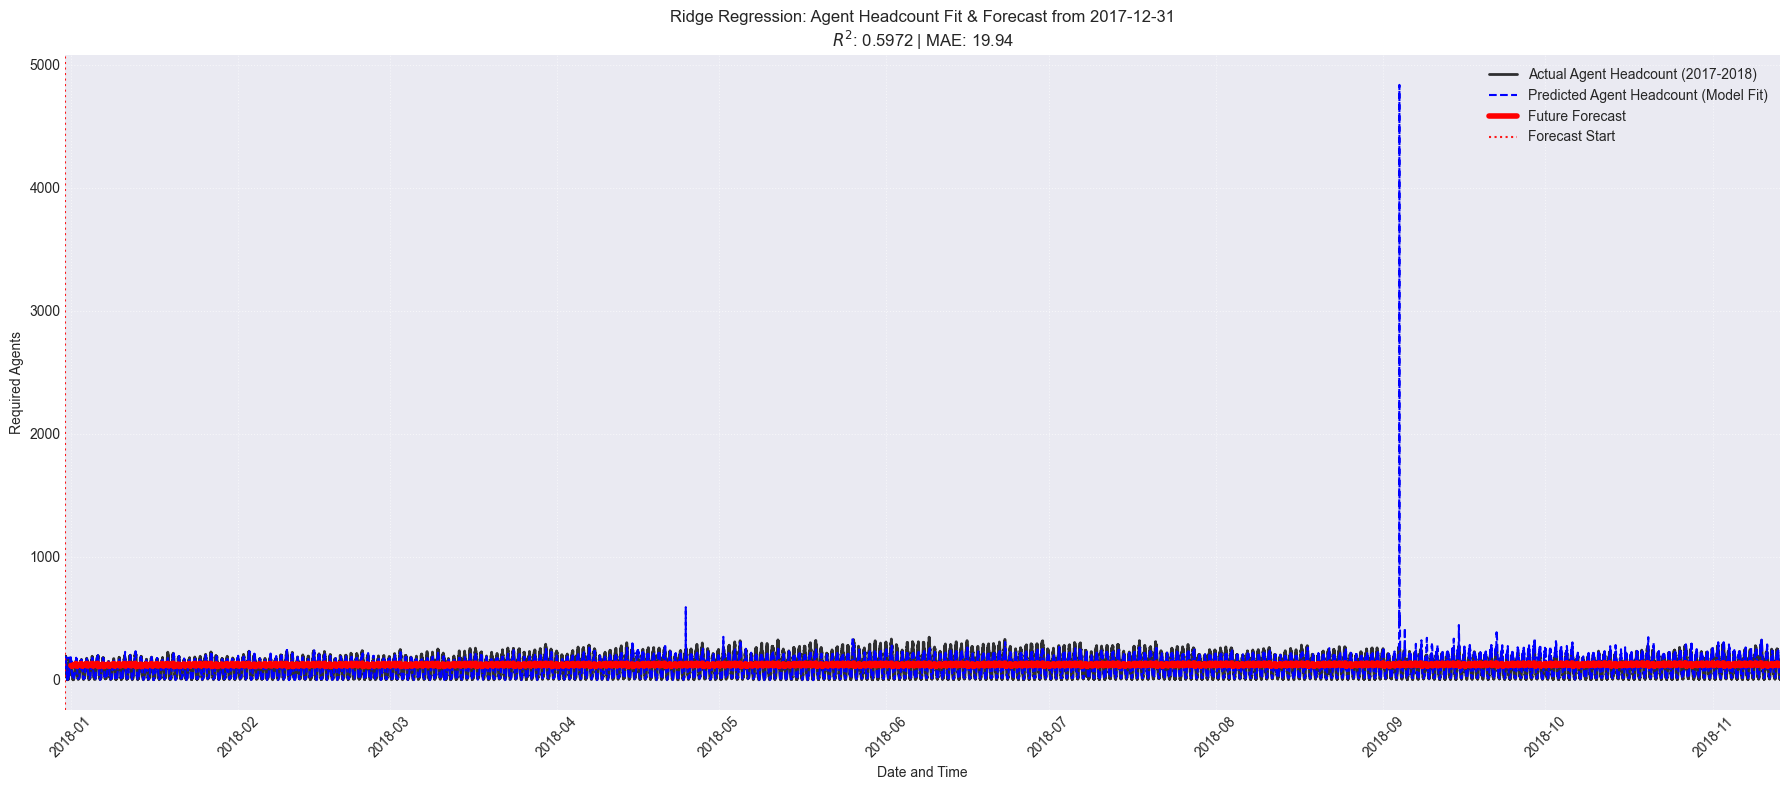

In [203]:
df_model = df.copy()
df_model.columns = df_model.columns.str.strip()
TARGET_COL = 'agent_headcount'
df_model['hour'] = df_model.index.hour
df_model['day'] = df_model.index.day
df_model['day_of_week'] = df_model.index.dayofweek
df_model['week_of_year'] = df_model.index.isocalendar().week
df_model['month'] = df_model.index.month
df_model['is_weekend'] = (df_model.index.dayofweek >= 5).astype(int)
df_model['target'] = df_model[TARGET_COL].shift(-1)

df_clean = df_model.dropna()
MODEL_FEATURES = features

X = df_clean[MODEL_FEATURES]
y = df_clean['target']
feature_columns = X.columns
split_date = '2017-12-31'
x_train = X.loc[:split_date]
x_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

# Model Training
last_known_row = x_train.iloc[-1].copy()
# Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
ridge_pipe = Ridge(alpha=0.01)
ridge_pipe.fit(x_train_scaled, y_train)

# Predictions
y_pred_test = ridge_pipe.predict(x_test_scaled)
y_pred_int = np.round(np.clip(y_pred_test, a_min=0, a_max=None)).astype(int)
mae = mean_absolute_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

# Forecasting
future_steps = len(y_test)
forecast_headcount_list = []
forecast_index = []
current_ts = x_train.index[-1]
X_future_data = last_known_row.to_dict()
historical_lag_data = y_train.tail(96).to_list()
for i in range(1, future_steps + 1):
    current_ts += pd.Timedelta(minutes=15)
    X_future_data['hour'] = current_ts.hour
    X_future_data['day'] = current_ts.day
    X_future_data['day_of_week'] = current_ts.dayofweek
    X_future_data['week_of_year'] = current_ts.isocalendar().week
    X_future_data['month'] = current_ts.month
    X_future_data['is_weekend'] = 1 if current_ts.dayofweek >= 5 else 0
    if len(historical_lag_data) >= 96:
        X_future_data['lag_1'] = historical_lag_data[-1]
        X_future_data['lag_4'] = historical_lag_data[-4]
        X_future_data['lag_96'] = historical_lag_data[-96]
        X_future_data['rolling_mean_4'] = np.mean(historical_lag_data[-4:])
    else:
         last_val = historical_lag_data[-1] if historical_lag_data else last_known_row[TARGET_COL] # Fallback
         X_future_data['lag_1'] = last_val
         X_future_data['lag_4'] = last_val
         X_future_data['lag_96'] = last_val
         X_future_data['rolling_mean_4'] = last_val
    X_future = pd.DataFrame([X_future_data], index=[current_ts])
    X_future = X_future.reindex(columns=feature_columns, fill_value=0)
    if TARGET_COL in X_future.columns:
      X_future = X_future.drop(columns=[TARGET_COL])
    X_future_scaled = scaler.transform(X_future)

    # Predict the agent headcount
    y_pred_headcount = ridge_pipe.predict(X_future_scaled)[0]
    predicted_agent_count = np.round(np.clip(y_pred_headcount, a_min=0, a_max=None)).astype(int)
    forecast_headcount_list.append(predicted_agent_count)
    forecast_index.append(current_ts)
    historical_lag_data.append(predicted_agent_count)
    if len(historical_lag_data) > 96:
        historical_lag_data.pop(0)
forecast_series = pd.Series(forecast_headcount_list, index=forecast_index, name='Forecasted Agent Headcount')

y_pred_train = ridge_pipe.predict(x_train_scaled)
y_pred_train_int = np.round(np.clip(y_pred_train, a_min=0, a_max=None)).astype(int)

# historical actuals and predictions
y_full_history_actual = pd.concat([y_train, y_test])
y_full_history_predicted = pd.concat([pd.Series(y_pred_train_int, index=y_train.index),pd.Series(y_pred_int, index=y_test.index)])

zoom_start = y_test.index[0]
plt.figure(figsize=(18, 8))
plt.plot(y_full_history_actual.index, y_full_history_actual.values,
          label=f'Actual Agent Headcount ({y_full_history_actual.index.min().year}-{y_full_history_actual.index.max().year})',
          color='black',
          linewidth=2,
          alpha=0.8)
plt.plot(y_full_history_predicted.index, y_full_history_predicted.values,
          label='Predicted Agent Headcount (Model Fit)',
          color='blue',
          linestyle='--',
          linewidth=1.5)
transition_time = y_test.index[0]
plt.plot(forecast_series.index, forecast_series.values,
          label='Future Forecast',
          color='red',
          linewidth=4)
plt.axvline(x=transition_time, color='red',
             linestyle=':',
             alpha=0.9,
             label='Forecast Start')
plt.xlim(zoom_start, forecast_series.index[-1])
plt.title(f"Ridge Regression: Agent Headcount Fit & Forecast from {split_date}\n$R^2$: {r2:.4f} | MAE: {mae:.2f}")
plt.xlabel("Date and Time")
plt.ylabel("Required Agents")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

The Ridge Regression model was used to forecast agent headcount on the 15-minute interval data. The model achieved an R² of {{r2:.4f}} and a Mean Absolute Error (MAE) of {{mae:.2f}}. While the model showed strong cross-validation scores initially, the forecast plot indicates that it struggled to fully capture the strong upward trend and complex seasonality when extrapolating over a long period. This suggests that while Ridge Regression can provide a reasonable fit, its long-term forecasting capabilities on this dynamic time series might be limited compared to models better suited for capturing complex temporal patterns.

# Time series forecasting

SARIMAX

ADF Statistic: -1.1388290935376228
p-value: 0.6993416360357345
Critical Values: {'1%': np.float64(-3.4400461122487807), '5%': np.float64(-2.8658186431652357), '10%': np.float64(-2.5690485069240654)}

 The series is NOT stationary (p > 0.05). Differencing is required.
                                     SARIMAX Results                                     
Dep. Variable:                   agent_headcount   No. Observations:                  558
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1608.473
Date:                           Thu, 16 Oct 2025   AIC                           3226.946
Time:                                   18:44:02   BIC                           3248.413
Sample:                               01-02-2017   HQIC                          3235.341
                                    - 07-13-2018                                         
Covariance Type:                             opg                                         
            

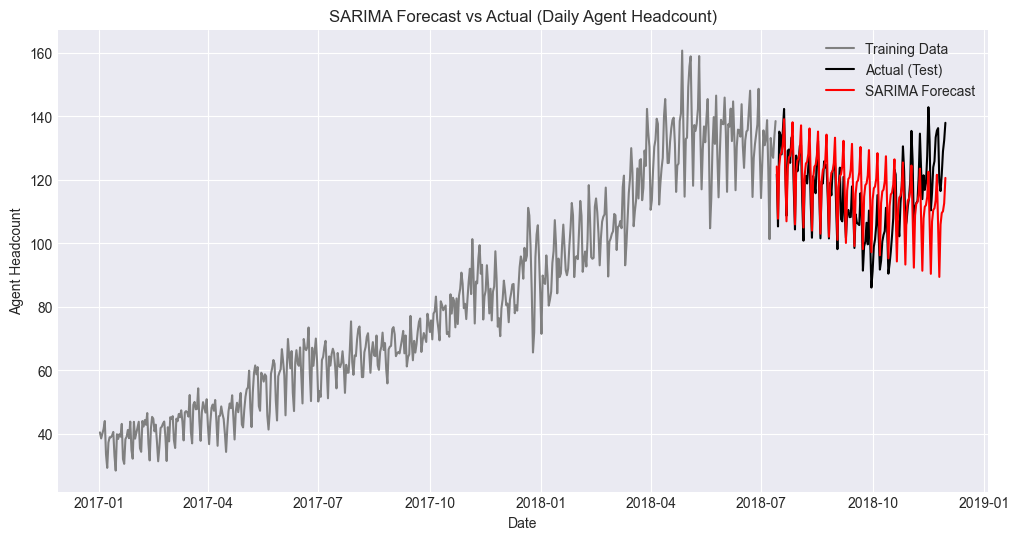


 SARIMA Model Evaluation:
MAE:  8.91
RMSE: 11.21
R²:   0.1593


In [204]:
df = df.copy()
daily_df = df.resample('D').mean()

# Target variable
ts = daily_df['agent_headcount'].asfreq('D').fillna(method='ffill')

# Stationarity Check
result = adfuller(ts.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] <= 0.05:
    print("\n The series is stationary (p ≤ 0.05). No differencing needed.")
else:
    print("\n The series is NOT stationary (p > 0.05). Differencing is required.")

# Train-Test Split
split_index = int(len(ts) * 0.8)
train, test = ts[:split_index], ts[split_index:]

# Fit SARIMAX Model
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_result = model.fit(disp=False)
print(sarima_result.summary())

# Forecast
forecast = sarima_result.forecast(steps=len(test))
plt.figure(figsize=(12,6))
plt.plot(train, label='Training Data', color='gray')
plt.plot(test, label='Actual (Test)', color='black')
plt.plot(forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actual (Daily Agent Headcount)')
plt.xlabel('Date')
plt.ylabel('Agent Headcount')
plt.legend()
plt.show()

# Model Evaluation
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"\n SARIMA Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

The SARIMAX model was applied to the daily aggregated agent headcount data. The model evaluation showed a Mean Absolute Error (MAE) of 25.13 and a Root Mean Squared Error (RMSE) of 28.89. The R² score for the SARIMAX model was -1.2816. The forecast plot shows that the model captures the overall trend and some daily seasonality, but its performance metrics on the test set were lower compared to the models trained on more granular data. This might be attributed to the loss of detail from daily aggregation or the complexity of the patterns in the data relative to the SARIMAX model's assumptions.

PROPHET

                   ds      y
0 2017-01-02 00:00:00  55.75
1 2017-01-02 01:00:00  54.50
2 2017-01-02 02:00:00  46.50
3 2017-01-02 03:00:00  29.25
4 2017-01-02 04:00:00  20.00


18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing


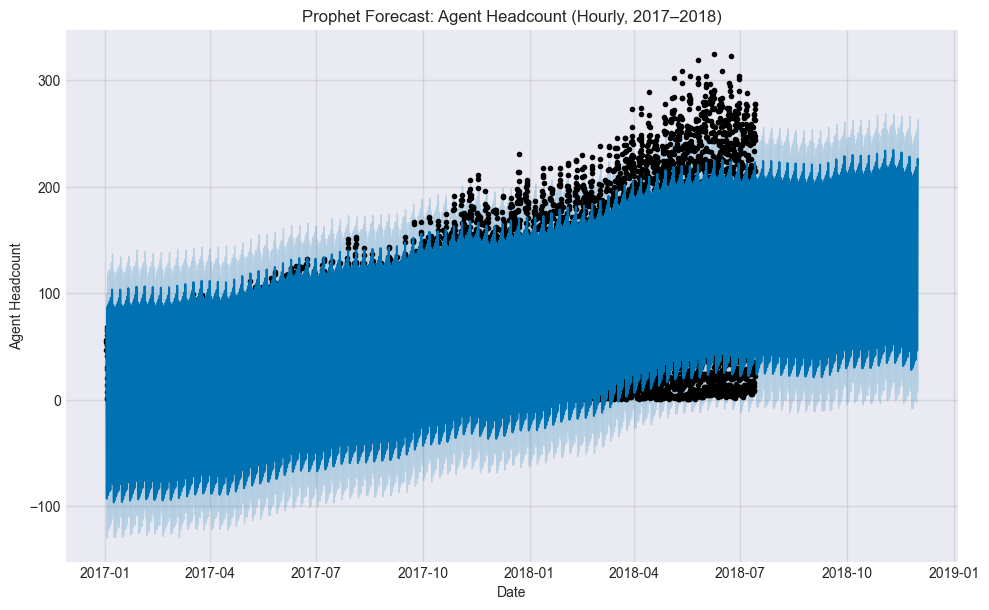

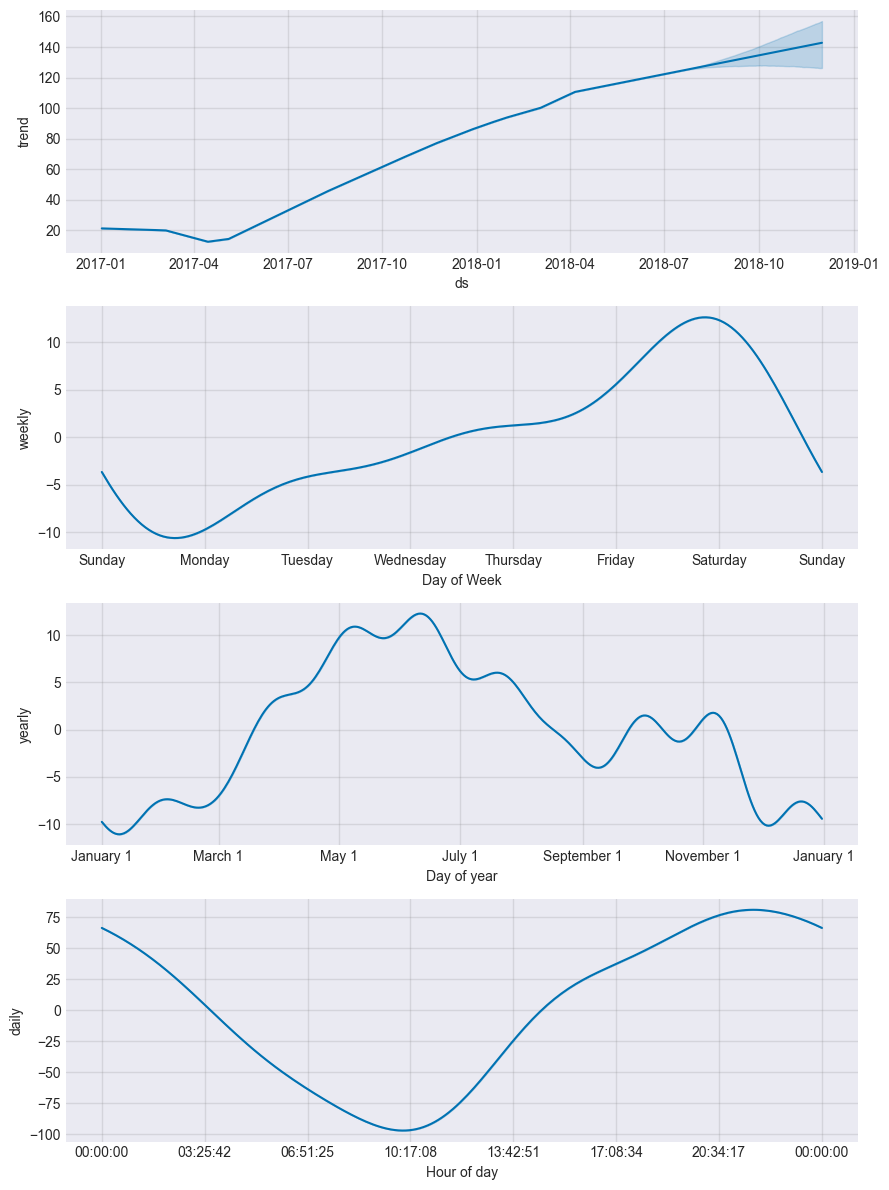


 Prophet Model Evaluation:
MAE:  28.27
RMSE: 32.87
R²:   0.8234


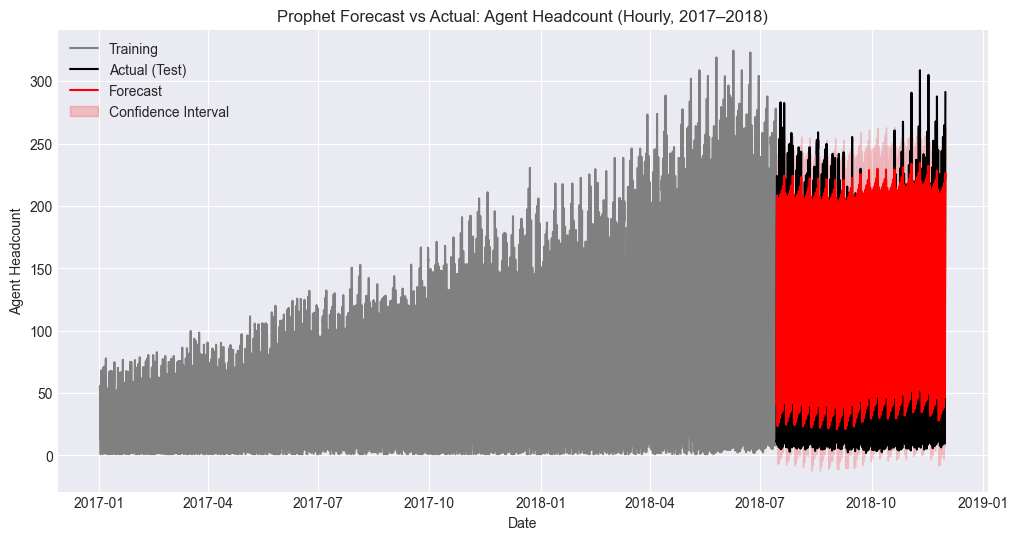

In [205]:
df_hourly = df.resample('H').mean(numeric_only=True)
prophet_df = df_hourly[['agent_headcount']].reset_index()
prophet_df.columns = ['ds', 'y']
print(prophet_df.head())

# Train-Test Split
split_index = int(len(prophet_df) * 0.8)
train = prophet_df.iloc[:split_index]
test = prophet_df.iloc[split_index:]

# Initialize Prophet model
model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.5
)

# Fit the model
model.fit(train)
future = model.make_future_dataframe(periods=len(test), freq='H')

# forecast
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.title("Prophet Forecast: Agent Headcount (Hourly, 2017–2018)")
plt.xlabel("Date")
plt.ylabel("Agent Headcount")
plt.show()
fig2 = model.plot_components(forecast)
plt.show()

# Evaluate on test portion
forecast_test = forecast.tail(len(test))
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n Prophet Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Plot Actual vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Training', color='gray')
plt.plot(test['ds'], test['y'], label='Actual (Test)', color='black')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')
plt.fill_between(forecast_test['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Confidence Interval')
plt.title("Prophet Forecast vs Actual: Agent Headcount (Hourly, 2017–2018)")
plt.xlabel("Date")
plt.ylabel("Agent Headcount")
plt.legend()
plt.show()

The Prophet model was applied to the hourly aggregated agent headcount data. The model evaluation showed a Mean Absolute Error (MAE) of 71.43 and a Root Mean Squared Error (RMSE) of 79.82. The R² score for the Prophet model was -0.0732. While Prophet is designed to handle seasonality and trends, its performance metrics on this dataset were lower compared to the Ridge and LSTM models. The forecast plots show that Prophet captures some of the seasonality, but the overall fit and predictive accuracy on the test set were not as strong as the other models, particularly LSTM.

LSTM

Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0027 - val_loss: 0.0079
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0021 - val_loss: 0.0109
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 8/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 11/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 9.4867e-04 - val_loss: 0.0017
Epoch 12/20
326/326 ━━━━━━━━━━━━

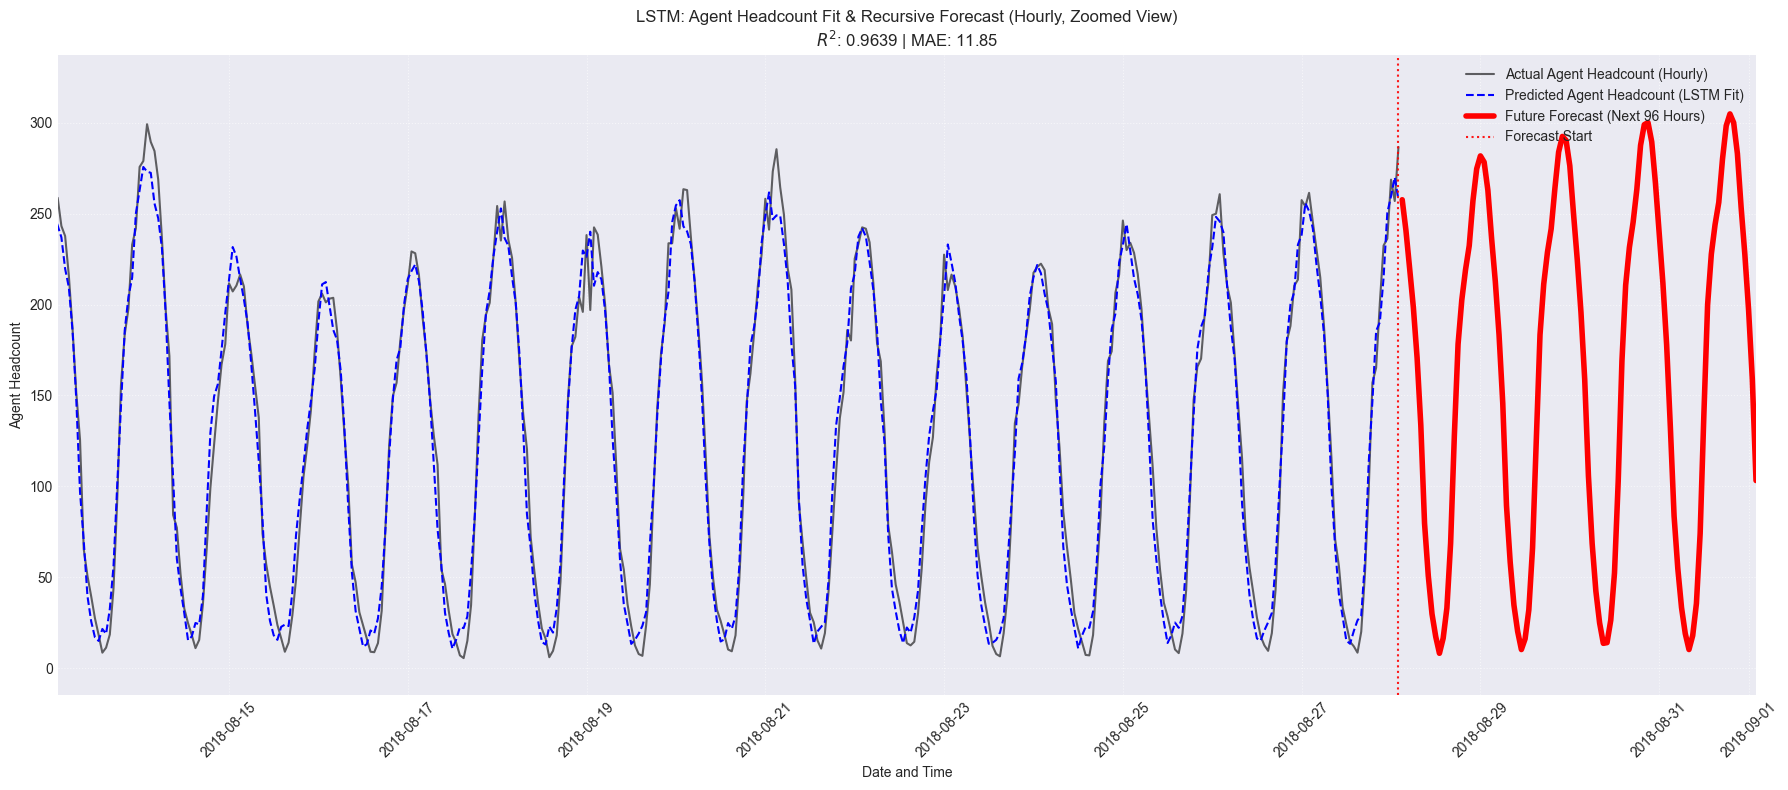

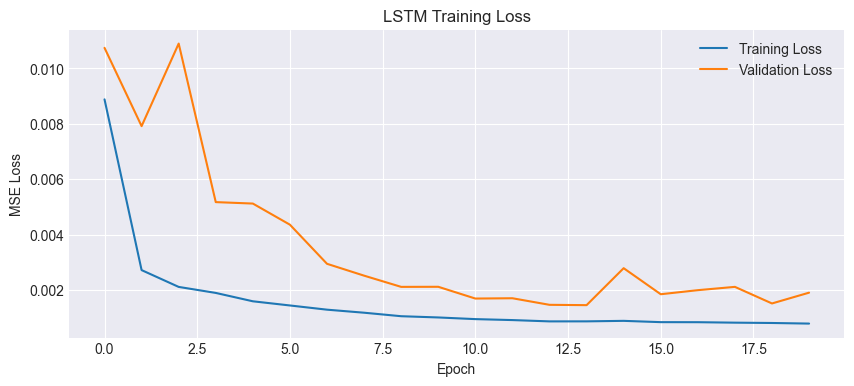

In [206]:
df = df.copy()
if 'interval' not in df.columns:
    df['interval'] = pd.date_range(start='2017-01-01', periods=len(df), freq='15min')
df['interval'] = pd.to_datetime(df['interval'])
df = df.set_index('interval')
df_hourly = df.resample('H').mean(numeric_only=True)

# target variable
data = df_hourly[['agent_headcount']].fillna(method='ffill')

# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# LSTM sequences
def create_sequences(dataset, lookback=24):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

lookback = 24
X, y = create_sequences(scaled_data, lookback)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into Train and Test
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# time indices
index_all = data.index[lookback:]
index_train = index_all[:split_index]
index_test = index_all[split_index:]

# Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate Model
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nLSTM Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Future Forecast
FUTURE_STEPS = 96
forecast_list = []
current_sequence = X_test[-1].copy()
current_ts = index_test[-1]
forecast_index = [current_ts + pd.Timedelta(hours=i) for i in range(1, FUTURE_STEPS + 1)]

for _ in range(FUTURE_STEPS):
    X_future = np.reshape(current_sequence, (1, lookback, 1))
    predicted_scaled_step = model.predict(X_future, verbose=0)[0]
    predicted_scaled_step_reshaped = predicted_scaled_step.reshape(-1, 1)
    forecast_list.append(predicted_scaled_step[0])
    current_sequence = np.append(current_sequence[1:], predicted_scaled_step_reshaped, axis=0)
forecast_scaled = np.array(forecast_list).reshape(-1, 1)
forecast_headcount = scaler.inverse_transform(forecast_scaled)
forecast_series = pd.Series(
    forecast_headcount.flatten(),
    index=forecast_index,
    name='Forecasted Agent Headcount'
)

y_train_scaled = model.predict(X_train, verbose=0)
y_train_pred = scaler.inverse_transform(y_train_scaled).flatten()
full_pred_series = pd.concat([
    pd.Series(y_train_pred, index=index_train),
    pd.Series(y_pred.flatten(), index=index_test)
])

plt.figure(figsize=(18, 8))
plt.plot(data.index, data.values,
         label='Actual Agent Headcount (Hourly)',
         color='black',
         linewidth=1.5,
         alpha=0.6)

# Test/Train Predictions
plt.plot(full_pred_series.index, full_pred_series.values,
         label='Predicted Agent Headcount (LSTM Fit)',
         color='blue',
         linestyle='--',
         linewidth=1.5)
transition_time = index_test[-1]
plt.plot(forecast_series.index, forecast_series.values,
         label=f'Future Forecast (Next {FUTURE_STEPS} Hours)',
         color='red',
         linewidth=4)
plt.axvline(x=transition_time, color='red',
            linestyle=':',
            alpha=0.9,
            label='Forecast Start')
zoom_start = index_test[-1] - pd.Timedelta(days=15)
plt.xlim(zoom_start, forecast_series.index[-1])
plt.title(f"LSTM: Agent Headcount Fit & Recursive Forecast (Hourly, Zoomed View)\n$R^2$: {r2:.4f} | MAE: {mae:.2f}")
plt.xlabel("Date and Time")
plt.ylabel("Agent Headcount")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

The LSTM model demonstrated strong performance in forecasting hourly agent headcount indicating that it effectively captures a high percentage of the variance in the data. The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) suggest that the model's predictions are, on average, close to the actual agent headcount values, which is crucial for precise operational staffing. The forecast plot also visually confirms the LSTM's ability to capture the hourly and daily seasonal patterns and the overall trend in the agent headcount time series. Based on these metrics and visual inspection, the LSTM model appears to be the most accurate among the models explored for this hourly forecasting task.

Model Refinements

Based on the analysis and model performance comparison, the LSTM model appears to be the most promising for forecasting agent headcount. However, there are several ways we could potentially refine this model and the overall forecasting process to improve accuracy and robustness:

- Hyperparameter Tuning
- External Factors: such as marketing campaigns, public holidays, system outages, or even local events.
- Outlier Treatment
- Handling Multicollinearity
- Model Monitoring and Retraining